# Análisis función objetivo

## Setup

## Análisis del log

In [ ]:
incumbent, best_bound = [], []
with open(filename, 'r', encoding='utf-8') as infile:
    wait = False
    read = False
    for line in infile:
        if wait:
            read = True
            wait = False
        if "Expl Unexpl" in line:
            wait = True
        if read:
            line = line.split()
            if len(line) == 10:
                time = int(line[-1].strip('s'))
                best_bound.append((float(line[-4]), time))
                if '%' in line[-3]:
                    incumbent.append((float(line[-5]), time))


In [ ]:
y = [i[0] for i in best_bound]
x = [i[1] for i in best_bound]
x = [round(i / (60 * 60), 3) for i in x]
min(x), max(x), min(y), max(y)

(0.004, 96.0, 650349.497, 850833.515)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_2d(name, x, y, start_in_0=True):
    plt.plot(x, y)

    print(y[-1], x[-1])

    print(max(x), min(y))

    plt.title(name)

    plt.xlabel("Time")
    plt.ylabel("Score")
    if start_in_0:
        plt.ylim(ymin=0)

    plt.grid(linestyle = ':', linewidth = 0.5)
    # plt.yticks(np.arange(min(y), max(y) + 1, 1.0))
    # plt.legend(['Mejor caso', 'Peor caso'])

    plt.show()

650349.497 96.0
96.0 650349.497


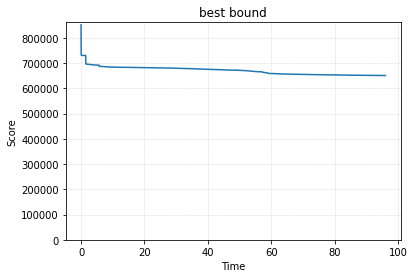

In [ ]:
plot_2d("best bound", x, y)

In [ ]:
y_incumbent = [i[0] for i in incumbent]
x_incumbent = [i[1] for i in incumbent]
x_incumbent = [round(i / (60 * 60), 3) for i in x_incumbent]
min(x_incumbent), max(x_incumbent), min(y_incumbent), max(y_incumbent)

(19.922, 96.0, 527688.0, 550664.0)

550664.0 96.0
96.0 527688.0


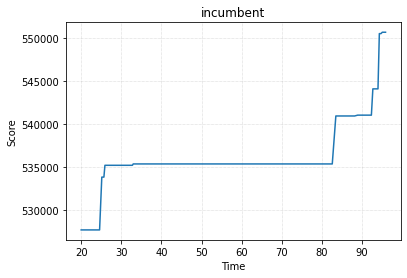

In [ ]:
plot_2d("incumbent", x_incumbent, y_incumbent, False)

## Análisis de pesos

In [1]:
beta_m, beta_p, z = {}, {}, {}

In [15]:
base_dir = '../logs/solutions'
champ = 'bosnia'
suffix = '12_20-21'
start_date = 23
filename_init = f'model-{champ}_{suffix}-init-0'
filename_opt = f'model-{champ}_{suffix}-opt-10'

In [44]:
with open(f'{base_dir}/{champ}/{filename_init}.sol', 'r', encoding='utf-8') as infile:
    for line in infile:
        line = line.strip()
        if 'beta' in line:
            var, value = line.split()
            _, var = var.split('[')
            var = var.strip(']')
            team, date = var.split(',')
            if 'beta_p' in line:
                beta_p[team, int(date)] = round(float(value))
            else:
                beta_m[team, int(date)] = round(float(value))
        if 'z' == line[0]:
            var, value = line.split()
            _, var = var.split('[')
            var = var.strip(']')
            team, date, p1, p2 = var.split(',')
            if float(value) > 0.5:
                value = 1
            else:
                value = 0
            z[(team, date, p1, p2)] = value

### Pesos función objetivo

In [45]:
P, F, I = [], [], []
w1, w2 = 1, 1

for team, date, p1, p2 in z.keys():
    P.append(round(float(p1)))
    P.append(round(float(p2)))
    F.append(round(float(date)))
    I.append(team)

P = list(set(P))
F = list(set(F))
I = list(set(I))

In [46]:
F.sort()

In [47]:
from itertools import product
# Ruvfi: R[posición, posición, fecha, equipo]
# peso en la función objetivo
RF = {}
for u, v, f, i in product(P, P, F, I):
    ud = abs(u - ((len(I) - 1) / 2 + 1.5))
    ld = abs(v - ((len(I) - 1) / 2 + 1.5))
    date_pond = (f - min(F) + 1) ** 2
    m_pond = 1
    if u == 1:
        m_pond += 0.3
    if v == len(I):
        m_pond += 0.2
    pen_pond = 1
    if u == v:
        pen_pond = 0
    final_pond = date_pond * pen_pond * m_pond
    RF[str((u, v, f, i))] = final_pond * (w1 * (max(ud, ld))**2 + w2 * (v - u)**2 + 1)

Se busca diccionario `dict[team, date] -> score`

In [48]:
date_team_score = {}

for var, value in z.items():
    if value == 1:
        team, date, p1, p2 = var
        date_team_score[(team, date)] = RF[str((int(p1), int(p2), int(date), team))]

In [49]:
arr = []
for team in I:
    line = []
    for date in F[:-1]:
        line.append(date_team_score[team, str(date)])
    arr.append(line)

In [50]:
arr

[[86.0, 292.0, 657.0, 1168.0, 1550.0, 2232.0, 2597.0, 2944.0, 3726.0, 4100.0],
 [107.0, 360.0, 558.0, 992.0, 1275.0, 1836.0, 2499.0, 2688.0, 2106.0, 1400.0],
 [158.0, 632.0, 1422.0, 2192.0, 2025.0, 1260.0, 441.0, 192.0, 243.0, 0.0],
 [90.0, 360.0, 459.0, 816.0, 1275.0, 1836.0, 2499.0, 2112.0, 1539.0, 600.0],
 [137.0, 404.0, 657.0, 1168.0, 1550.0, 2232.0, 3038.0, 2944.0, 3726.0, 3800.0],
 [137.0, 548.0, 774.0, 1376.0, 1825.0, 2628.0, 3038.0, 1664.0, 486.0, 0.0],
 [51.0, 204.0, 459.0, 816.0, 1050.0, 1512.0, 2058.0, 2688.0, 2430.0, 3000.0],
 [137.0, 472.0, 774.0, 1168.0, 1825.0, 2628.0, 3038.0, 1664.0, 1134.0, 0.0],
 [86.0, 292.0, 657.0, 1168.0, 1825.0, 2232.0, 3038.0, 3968.0, 4293.0, 1800.0],
 [107.0, 300.0, 459.0, 816.0, 1275.0, 1512.0, 2058.0, 2688.0, 2835.0, 3000.0],
 [73.0, 292.0, 657.0, 1168.0, 1825.0, 2232.0, 3038.0, 3392.0, 3726.0, 3000.0],
 [107.0, 360.0, 558.0, 816.0, 1275.0, 1836.0, 2499.0, 2688.0, 3402.0, 3500.0]]

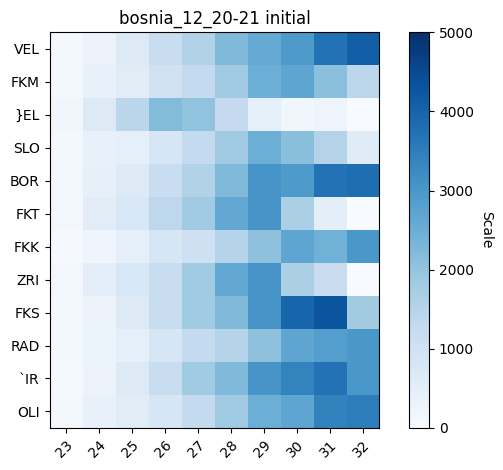

In [53]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

heat = np.array(arr)

norm = matplotlib.colors.Normalize(vmin=0, vmax=5000)

fig, ax = plt.subplots()
im = ax.imshow(heat, cmap='Blues', norm=norm)

ax.set_xticks(np.arange(len(F) - 1))
ax.set_xticklabels(F[:-1])
ax.set_yticks(np.arange(len(I)))
ax.set_yticklabels(I)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Scale', rotation=-90, va="bottom")

ax.set_title(f"{champ}_{suffix} initial")
fig.tight_layout()
plt.show()

### Line plot per teams

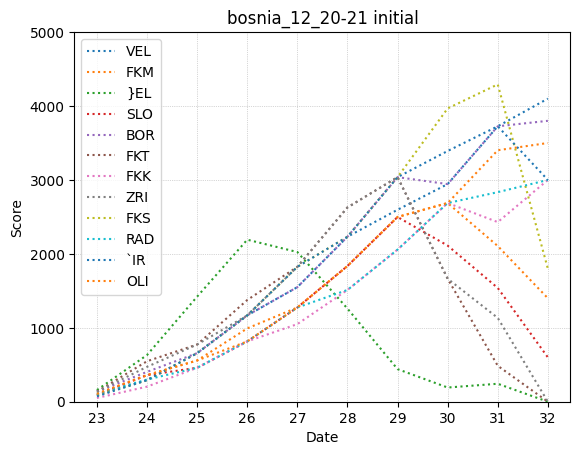

In [54]:
for data in arr:
    plt.plot(data, linestyle = 'dotted')

plt.title(f"{champ}_{suffix} initial")

plt.xlabel("Date")
plt.ylabel("Score")
plt.ylim(0, 5000)

plt.xticks(range(len(F[:-1])), F[:-1])

plt.grid(linestyle = ':', linewidth = 0.5)
plt.legend(I)

plt.show()

In [24]:
for team, val in zip(I, arr):
    val = [str(i) + ',' for i in val]
    val[-1] = val[-1][:-1]
    if len(team) == 2: team += " "
    print(team, " ".join([f'{i: <7}' for i in val]))

VEL 4100.0, 19118.0, 86.0,   292.0,  657.0,  1168.0, 1825.0, 2628.0, 3038.0, 3968.0 
FKM 4200.0, 19118.0, 126.0,  428.0,  675.0,  816.0,  1275.0, 1836.0, 2058.0, 2688.0 
}EL 0.0,    19118.0, 73.0,   632.0,  1422.0, 2192.0, 2950.0, 1908.0, 147.0,  0.0    
SLO 1400.0, 19118.0, 107.0,  428.0,  558.0,  992.0,  1275.0, 1836.0, 2058.0, 2688.0 
BOR 4100.0, 19118.0, 137.0,  404.0,  657.0,  1168.0, 1825.0, 2628.0, 3038.0, 3968.0 
FKT 0.0,    19118.0, 137.0,  548.0,  1062.0, 1376.0, 1825.0, 2628.0, 3577.0, 2688.0 
FKK 3500.0, 19118.0, 51.0,   204.0,  459.0,  816.0,  1050.0, 1512.0, 2058.0, 2688.0 
ZRI 1100.0, 19118.0, 137.0,  548.0,  909.0,  1168.0, 1825.0, 2628.0, 3577.0, 3968.0 
FKS 2100.0, 19118.0, 101.0,  404.0,  657.0,  1168.0, 1825.0, 2628.0, 3038.0, 3968.0 
RAD 3500.0, 19118.0, 107.0,  360.0,  558.0,  816.0,  1275.0, 1512.0, 2058.0, 2688.0 
`IR 4600.0, 19118.0, 86.0,   292.0,  657.0,  1168.0, 1825.0, 2232.0, 3038.0, 3392.0 
OLI 4200.0, 19118.0, 126.0,  360.0,  558.0,  816.0,  1050.0, 1512